In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuspar

In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os

In [ ]:
# Load the ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU

# Directory to store captured images
if not os.path.exists('captured_images'):
    os.makedirs('captured_images')

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 52223.68KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:

# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            # Extract bounding box and depth information
            bboxC = detection.location_data.relative_bounding_box
            depth = detection.score[0]  # Depth confidence (as a proxy)

            # Filter based on depth
            if depth > depth_threshold:
                bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                       int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                return face
    return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    faces = model.get(face_img)
    if len(faces) > 0:
        return faces[0].embedding
    else:
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    stored_image = cv2.imread(stored_image_path)
    new_image = data_uri_to_image(new_image)

    stored_face = detect_and_filter_faces(stored_image)
    new_face = detect_and_filter_faces(new_image)

    if stored_face is not None and new_face is not None:
        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            return match, accuracy_percentage
    return False, 0

# Function to process and compare captured images
def process_and_compare_image(imgData):
    img = data_uri_to_image(imgData)

    # Save the new captured image
    new_image_path = 'captured_images/new_image.jpg'
    cv2.imwrite(new_image_path, img)

    # Compare the new image with the stored image
    match, accuracy = compare_faces('captured_images/captured_image.jpg', imgData)

    # Display the result
    if match:
        result_text = f"Faces match with an accuracy of {accuracy:.2f}%."
    else:
        result_text = f"Faces do not match. Accuracy: {accuracy:.2f}%."

    display(Javascript(f'''
        alert("{result_text}");
    '''))

# Function to capture and process images
def process_image(imgData):
    img = data_uri_to_image(imgData)
    face = detect_and_filter_faces(img)

    if face is not None:
        # Save the captured image
        cv2.imwrite('captured_images/captured_image.jpg', face)

        # Display the image
        _, buffer = cv2.imencode('.jpg', face)
        img_str = b64encode(buffer).decode()
        display(Javascript('''
            var img = document.createElement('img');
            img.src = "data:image/jpeg;base64,{}";
            document.body.appendChild(img);
        '''.format(img_str)))

In [ ]:







# Register the process_image and process_and_compare_image functions to be callable from JavaScript
from google.colab import output
output.register_callback('process_image', process_image)
output.register_callback('process_and_compare_image', process_and_compare_image)

from IPython.display import Javascript, display

def start_camera():
    display(Javascript('''
        var video;
        var div = document.createElement('div');
        var captureButton = document.createElement('button');
        var compareButton = document.createElement('button');
        var stream;

        function startCamera() {
            video = document.createElement('video');
            video.style.display = 'block';
            video.style.margin = '0 auto';
            div.appendChild(video);

            if (navigator.mediaDevices.getUserMedia) {
                navigator.mediaDevices.getUserMedia({ video: true })
                    .then(function (stream) {
                        video.srcObject = stream;
                        video.play();
                        window.stream = stream;
                    })
                    .catch(function (error) {
                        console.error('Error accessing media devices.', error);
                    });
            } else {
                console.error('getUserMedia not supported');
            }

            var canvas = document.createElement('canvas');
            canvas.width = 300;
            canvas.height = 300;
            canvas.style.display = 'none';
            div.appendChild(canvas);

            captureButton.textContent = 'Capture';
            captureButton.style.display = 'block';
            captureButton.style.margin = '10px auto';
            div.appendChild(captureButton);

            captureButton.onclick = function() {
                var context = canvas.getContext('2d');
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                var imgData = canvas.toDataURL('image/jpeg');
                google.colab.kernel.invokeFunction('process_image', [imgData], {});
            };

            compareButton.textContent = 'Compare';
            compareButton.style.display = 'block';
            compareButton.style.margin = '10px auto';
            div.appendChild(compareButton);

            compareButton.onclick = function() {
                var context = canvas.getContext('2d');
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                var imgData = canvas.toDataURL('image/jpeg');
                google.colab.kernel.invokeFunction('process_and_compare_image', [imgData], {});
            };

            document.body.appendChild(div);
        }

        function stopCamera() {
            if (window.stream) {
                window.stream.getVideoTracks()[0].stop();
                div.remove();
            }
        }

        // Adding buttons to the notebook interface
        var startButton = document.createElement('button');
        startButton.textContent = 'Start Camera';
        startButton.onclick = startCamera;
        document.body.appendChild(startButton);

        var stopButton = document.createElement('button');
        stopButton.textContent = 'Stop Camera';
        stopButton.onclick = stopCamera;
        document.body.appendChild(stopButton);
    '''))


In [ ]:

start_camera()


<IPython.core.display.Javascript object>

## Attempt 2


In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe ipywidgets


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from base64 import b64decode, b64encode
import os
from IPython.display import display
import ipywidgets as widgets
from IPython.display import Image

In [ ]:
# Load the ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU

# Directory to store captured images
if not os.path.exists('captured_images'):
    os.makedirs('captured_images')

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:





# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            # Extract bounding box and depth information
            bboxC = detection.location_data.relative_bounding_box
            depth = detection.score[0]  # Depth confidence (as a proxy)

            # Filter based on depth
            if depth > depth_threshold:
                bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                       int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                return face
    return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    faces = model.get(face_img)
    if len(faces) > 0:
        return faces[0].embedding
    else:
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    stored_image = cv2.imread(stored_image_path)
    new_image = data_uri_to_image(new_image)

    stored_face = detect_and_filter_faces(stored_image)
    new_face = detect_and_filter_faces(new_image)

    if stored_face is not None and new_face is not None:
        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            return match, accuracy_percentage
    return False, 0



In [ ]:
# Widgets for camera display and buttons
image_widget = widgets.Image(format='jpeg')
capture_button = widgets.Button(description="Capture")
compare_button = widgets.Button(description="Compare")
output_widget = widgets.Output()

# Display the widgets
display(image_widget, capture_button, compare_button, output_widget)

# Function to capture image from webcam
def capture_image(change):
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        return

    # Convert the captured frame to a displayable format
    _, buffer = cv2.imencode('.jpg', frame)
    img_str = b64encode(buffer).decode()
    image_widget.value = buffer.tobytes()

    # Process and save the captured image
    process_image(img_str)

# Function to compare captured image with stored image
def compare_image(change):
    img_str = image_widget.value
    process_and_compare_image(img_str)

# Function to process captured image
def process_image(img_str):
    img = data_uri_to_image("data:image/jpeg;base64," + img_str.decode())
    face = detect_and_filter_faces(img)

    if face is not None:
        # Save the captured image
        cv2.imwrite('captured_images/captured_image.jpg', face)

# Function to process and compare captured images
def process_and_compare_image(img_str):
    img = data_uri_to_image("data:image/jpeg;base64," + img_str.decode())
    match, accuracy = compare_faces('captured_images/captured_image.jpg', img)

    # Display the result
    with output_widget:
        output_widget.clear_output()
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Capture image on button click
capture_button.on_click(capture_image)

# Compare image on button click
compare_button.on_click(compare_image)

# Start capturing video
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if ret:
        _, buffer = cv2.imencode('.jpg', frame)
        image_widget.value = buffer.tobytes()

cap.release()

Image(value=b'', format='jpeg')

Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

KeyboardInterrupt: 

Failed to capture image
Failed to capture image
Failed to capture image
Failed to capture image
Failed to capture image
Failed to capture image


error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:813: error: (-215:Assertion failed) !buf.empty() in function 'imdecode_'


error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:813: error: (-215:Assertion failed) !buf.empty() in function 'imdecode_'


Failed to capture image
Failed to capture image


error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:813: error: (-215:Assertion failed) !buf.empty() in function 'imdecode_'


## Attempt 3

In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe


In [ ]:
import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output

In [ ]:



# Load the ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU

# Directory to store captured images
if not os.path.exists('captured_images'):
    os.makedirs('captured_images')

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            # Extract bounding box and depth information
            bboxC = detection.location_data.relative_bounding_box
            depth = detection.score[0]  # Depth confidence (as a proxy)

            # Filter based on depth
            if depth > depth_threshold:
                bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                       int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                return face
    return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    faces = model.get(face_img)
    if len(faces) > 0:
        return faces[0].embedding
    else:
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    stored_image = cv2.imread(stored_image_path)
    new_image = data_uri_to_image(new_image)

    stored_face = detect_and_filter_faces(stored_image)
    new_face = detect_and_filter_faces(new_image)

    if stored_face is not None and new_face is not None:
        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            return match, accuracy_percentage
    return False, 0

# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    if match:
        print(f"Faces match with an accuracy of {accuracy:.2f}%.")
    else:
        print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Capture button
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

# Compare button
compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: capture_image_js())
display(compare_button)


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

<IPython.core.display.Javascript object>

Image captured and saved!


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image captured and saved!
Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


## Attempt 4

In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe

In [ ]:
import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output

In [ ]:

# Load the ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU

# Directory to store captured images
if not os.path.exists('captured_images'):
    os.makedirs('captured_images')

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:




# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            # Extract bounding box and depth information
            bboxC = detection.location_data.relative_bounding_box
            depth = detection.score[0]  # Depth confidence (as a proxy)

            # Filter based on depth
            if depth > depth_threshold:
                bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                       int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                return face
    return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    faces = model.get(face_img)
    if len(faces) > 0:
        return faces[0].embedding
    else:
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    stored_image = cv2.imread(stored_image_path)
    new_image = data_uri_to_image(new_image)

    stored_face = detect_and_filter_faces(stored_image)
    new_face = detect_and_filter_faces(new_image)

    if stored_face is not None and new_face is not None:
        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            return match, accuracy_percentage
    return False, 0

# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    if match:
        print(f"Faces match with an accuracy of {accuracy:.2f}%.")
    else:
        print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Capture button
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

# Compare button
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))



Button(description='Capture', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!
Image captured and saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image captured and saved!
Image captured and saved!
Image captured and saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image captured and saved!
Image captured and saved!


In [ ]:
compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)


Button(description='Compare', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Attempt 4

In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe

In [ ]:

import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

In [ ]:



# Load the ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU

# Directory to store captured images
if not os.path.exists('captured_images'):
    os.makedirs('captured_images')

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:


# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            # Extract bounding box and depth information
            bboxC = detection.location_data.relative_bounding_box
            depth = detection.score[0]  # Depth confidence (as a proxy)

            # Filter based on depth
            if depth > depth_threshold:
                bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                       int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                return face
    return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    faces = model.get(face_img)
    if len(faces) > 0:
        return faces[0].embedding
    else:
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    stored_image = cv2.imread(stored_image_path)
    new_image = data_uri_to_image(new_image)

    stored_face = detect_and_filter_faces(stored_image)
    new_face = detect_and_filter_faces(new_image)

    if stored_face is not None and new_face is not None:
        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            return match, accuracy_percentage
    return False, 0

# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")


In [ ]:

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

Image captured and saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Attempt 6

In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe

import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

print("Packages installed and libraries imported successfully.")


Packages installed and libraries imported successfully.


In [ ]:
# Load the ArcFace model
try:
    model = insightface.app.FaceAnalysis(name='buffalo_l')
    model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU
    print("ArcFace model loaded successfully.")
except Exception as e:
    print(f"Error loading ArcFace model: {e}")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
ArcFace mode

In [ ]:
# Directory to store captured images
try:
    if not os.path.exists('captured_images'):
        os.makedirs('captured_images')
    print("Directory for captured images is ready.")
except Exception as e:
    print(f"Error setting up directory: {e}")


Directory for captured images is ready.


In [ ]:
# Initialize Mediapipe Face Detection
try:
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
    print("Mediapipe face detection initialized successfully.")
except Exception as e:
    print(f"Error initializing Mediapipe face detection: {e}")


Mediapipe face detection initialized successfully.


In [ ]:
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Filter based on depth
                if depth > depth_threshold:
                    bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                           int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                    face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                    print("Face detected and filtered based on depth.")
                    return face
        print("No face detected or depth threshold not met.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        faces = model.get(face_img)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None


In [ ]:
# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        stored_image = cv2.imread(stored_image_path)
        new_image = data_uri_to_image(new_image)

        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0

        if new_image is None:
            print("New image could not be decoded.")
            return False, 0

        stored_face = detect_and_filter_faces(stored_image)
        new_face = detect_and_filter_faces(new_image)

        if stored_face is None or new_face is None:
            print("Failed to detect face in one of the images.")
            return False, 0

        stored_embedding = get_face_embedding(stored_face)
        new_embedding = get_face_embedding(new_face)

        if stored_embedding is not None and new_embedding is not None:
            similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
            accuracy_percentage = similarity * 100
            match = similarity > 0.6  # Threshold for a match
            print(f"Face comparison completed. Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
            return match, accuracy_percentage
        else:
            print("Face embedding failed for one or both faces.")
            return False, 0
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: capture_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


## UPDATED CELL 6

In [ ]:
# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None:
            print("No face detected in stored image.")
            return False, 0
        print("Face detected in stored image.")

        new_face = detect_and_filter_faces(new_image)
        if new_face is None:
            print("No face detected in new image.")
            return False, 0
        print("Face detected in new image.")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: capture_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


## New Veraion Attempt 8

In [ ]:
!pip install torch torchvision insightface opencv-python mediapipe

import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

print("Packages installed and libraries imported successfully.")


Packages installed and libraries imported successfully.


In [ ]:
# Load the ArcFace model
try:
    model = insightface.app.FaceAnalysis(name='buffalo_l')
    model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU
    print("ArcFace model loaded successfully.")
except Exception as e:
    print(f"Error loading ArcFace model: {e}")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
ArcFace mode

In [ ]:
# Directory to store captured images
try:
    if not os.path.exists('captured_images'):
        os.makedirs('captured_images')
    print("Directory for captured images is ready.")
except Exception as e:
    print(f"Error setting up directory: {e}")


Directory for captured images is ready.


In [ ]:
# Initialize Mediapipe Face Detection
try:
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
    print("Mediapipe face detection initialized successfully.")
except Exception as e:
    print(f"Error initializing Mediapipe face detection: {e}")


Mediapipe face detection initialized successfully.


In [ ]:
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information
def detect_and_filter_faces(image, depth_threshold=0.5):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Filter based on depth
                if depth > depth_threshold:
                    bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
                           int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])
                    face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                    print("Face detected and filtered based on depth.")
                    return face
        print("No face detected or depth threshold not met.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        faces = model.get(face_img)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None


In [ ]:
# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None:
            print("No face detected in stored image.")
            return False, 0
        print("Face detected in stored image.")

        new_face = detect_and_filter_faces(new_image)
        if new_face is None:
            print("No face detected in new image.")
            return False, 0
        print("Face detected in new image.")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected and filtered based on depth.
Face detected in stored image.
Face detected and filtered based on depth.
Face detected in new image.
Error extracting face embedding: float division by zero
Failed to extract embedding from stored face.


## ATTEMPT 9, REVISING CELL 6

In [ ]:
# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Debugging: Check the sizes and data types of the faces
        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        # Debugging: Check the norms before division to avoid division by zero
        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected and filtered based on depth.
Face detected in stored image.
Face detected and filtered based on depth.
Face detected in new image.
Stored face shape: (10, 10, 3), dtype: uint8
New face shape: (173, 173, 3), dtype: uint8
No face detected in the image for embedding.
Failed to extract embedding from stored face.


# attempt 10 , replace CELL 6

In [ ]:
# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Check if the face size is sufficient for embedding extraction
        min_face_size = 50  # Minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected and filtered based on depth.
No face detected in stored image or face image has zero size.


# Attempt 11 , more debugging replace CELL 6

In [ ]:
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Display the stored face image for debugging
        cv2_imshow(stored_face)

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Display the new face image for debugging
        cv2_imshow(new_face)

        # Increase the minimum size for face detection
        min_face_size = 80  # Increased minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected and filtered based on depth.
Face detected in stored image.


Face detected and filtered based on depth.
Face detected in new image.


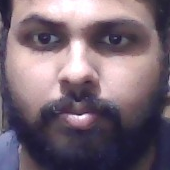

Stored face too small for embedding extraction: (5, 5, 3)


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


## ATTEMPT 12, REPLACE CELL 6

In [ ]:
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Debug: Print out the bounding box coordinates
        print(f"Stored face size: {stored_face.shape}")
        cv2_imshow(stored_face)  # Display the stored face

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Debug: Print out the bounding box coordinates
        print(f"New face size: {new_face.shape}")
        cv2_imshow(new_face)  # Display the new face

        # Increase the minimum size for face detection
        min_face_size = 80  # Increased minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected and filtered based on depth.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected and filtered based on depth.
Face detected in stored image.
Stored face size: (7, 5, 3)


Face detected and filtered based on depth.
Face detected in new image.
New face size: (165, 165, 3)


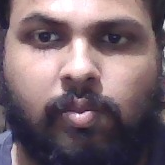

Stored face too small for embedding extraction: (7, 5, 3)


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


## ATTEMPT 14, CHANGED BOUNDING BOX

In [ ]:
#CELL 1
!pip install torch torchvision insightface opencv-python mediapipe

import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

print("Packages installed and libraries imported successfully.")

Packages installed and libraries imported successfully.


In [ ]:
#CELL 2
# Load the ArcFace model
try:
    model = insightface.app.FaceAnalysis(name='buffalo_l')
    model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU
    print("ArcFace model loaded successfully.")
except Exception as e:
    print(f"Error loading ArcFace model: {e}")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
ArcFace mode

In [ ]:
# CELL 3
# Directory to store captured images
try:
    if not os.path.exists('captured_images'):
        os.makedirs('captured_images')
    print("Directory for captured images is ready.")
except Exception as e:
    print(f"Error setting up directory: {e}")

Directory for captured images is ready.


In [ ]:
# CELL 4
# Initialize Mediapipe Face Detection
try:
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
    print("Mediapipe face detection initialized successfully.")
except Exception as e:
    print(f"Error initializing Mediapipe face detection: {e}")


Mediapipe face detection initialized successfully.


In [ ]:
# CELL 5
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information and minimum size enforcement
def detect_and_filter_faces(image, depth_threshold=0.5, min_face_size=(80, 80)):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Calculate the bounding box size
                bbox_width = int(bboxC.width * image.shape[1])
                bbox_height = int(bboxC.height * image.shape[0])

                # Filter based on depth and minimum face size
                if depth > depth_threshold and bbox_width >= min_face_size[0] and bbox_height >= min_face_size[1]:
                    bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), bbox_width, bbox_height
                    face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                    print(f"Face detected with size: {face.shape}")
                    return face

        print("No face detected or face size below minimum threshold.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        faces = model.get(face_img)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None


In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Debug: Print out the bounding box coordinates
        print(f"Stored face size: {stored_face.shape}")
        cv2_imshow(stored_face)  # Display the stored face

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Debug: Print out the bounding box coordinates
        print(f"New face size: {new_face.shape}")
        cv2_imshow(new_face)  # Display the new face

        # Increase the minimum size for face detection
        min_face_size = 80  # Increased minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Face detected with size: (163, 163, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Face detected with size: (8, 8, 3)
Face detected in stored image.
Stored face size: (8, 8, 3)


Face detected with size: (170, 170, 3)
Face detected in new image.
New face size: (170, 170, 3)


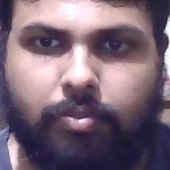

Stored face too small for embedding extraction: (8, 8, 3)


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# attempt 15, RE-RUN 5,6,7

In [ ]:
# CELL 5
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information and strict minimum size enforcement
def detect_and_filter_faces(image, depth_threshold=0.5, min_face_size=(100, 100)):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Calculate the bounding box size
                bbox_width = int(bboxC.width * image.shape[1])
                bbox_height = int(bboxC.height * image.shape[0])

                # Debug: Print the bounding box coordinates and size
                print(f"Bounding box width: {bbox_width}, height: {bbox_height}")
                print(f"Bounding box coordinates: x={bboxC.xmin}, y={bboxC.ymin}")

                # Filter based on depth and minimum face size
                if depth > depth_threshold and bbox_width >= min_face_size[0] and bbox_height >= min_face_size[1]:
                    bbox = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), bbox_width, bbox_height

                    # Safeguard against zero dimensions
                    if bbox_width == 0 or bbox_height == 0:
                        print("Bounding box has zero width or height, skipping this face.")
                        continue

                    face = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
                    print(f"Face detected with size: {face.shape}")
                    return face

        print("No face detected or face size below minimum threshold.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        faces = model.get(face_img)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None


In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Debug: Print out the bounding box coordinates
        print(f"Stored face size: {stored_face.shape}")
        cv2_imshow(stored_face)  # Display the stored face

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Debug: Print out the bounding box coordinates
        print(f"New face size: {new_face.shape}")
        cv2_imshow(new_face)  # Display the new face

        # Increase the minimum size for face detection
        min_face_size = 80  # Increased minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Bounding box width: 156, height: 156
Bounding box coordinates: x=0.38360074162483215, y=0.4888092279434204
Face detected with size: (156, 156, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Bounding box width: 173, height: 173
Bounding box coordinates: x=-0.10010670125484467, y=-0.10005906224250793
Face detected with size: (15, 15, 3)
Face detected in stored image.
Stored face size: (15, 15, 3)


Bounding box width: 160, height: 160
Bounding box coordinates: x=0.37945908308029175, y=0.497623085975647
Face detected with size: (160, 160, 3)
Face detected in new image.
New face size: (160, 160, 3)


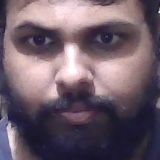

Stored face too small for embedding extraction: (15, 15, 3)


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# ATTEMPT 19 , CLIPPING BOUNDING BOX

In [ ]:
# CELL 5
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information and strict minimum size enforcement
def detect_and_filter_faces(image, depth_threshold=0.5, min_face_size=(100, 100)):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Calculate the bounding box size and coordinates
                bbox_xmin = max(int(bboxC.xmin * image.shape[1]), 0)
                bbox_ymin = max(int(bboxC.ymin * image.shape[0]), 0)
                bbox_width = int(bboxC.width * image.shape[1])
                bbox_height = int(bboxC.height * image.shape[0])

                # Clip the bounding box coordinates to stay within image boundaries
                bbox_xmax = min(bbox_xmin + bbox_width, image.shape[1])
                bbox_ymax = min(bbox_ymin + bbox_height, image.shape[0])

                # Ensure the width and height are calculated correctly after clipping
                bbox_width = bbox_xmax - bbox_xmin
                bbox_height = bbox_ymax - bbox_ymin

                # Debug: Print the bounding box coordinates and size
                print(f"Clipped bounding box width: {bbox_width}, height: {bbox_height}")
                print(f"Clipped bounding box coordinates: x={bbox_xmin}, y={bbox_ymin}")

                # Filter based on depth and minimum face size
                if depth > depth_threshold and bbox_width >= min_face_size[0] and bbox_height >= min_face_size[1]:
                    face = image[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
                    print(f"Face detected with size: {face.shape}")
                    return face

        print("No face detected or face size below minimum threshold.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        faces = model.get(face_img)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None


In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Debug: Print out the bounding box coordinates
        print(f"Stored face size: {stored_face.shape}")
        cv2_imshow(stored_face)  # Display the stored face

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Debug: Print out the bounding box coordinates
        print(f"New face size: {new_face.shape}")
        cv2_imshow(new_face)  # Display the new face

        # Increase the minimum size for face detection
        min_face_size = 80  # Increased minimum size for face detection
        if stored_face.shape[0] < min_face_size or stored_face.shape[1] < min_face_size:
            print(f"Stored face too small for embedding extraction: {stored_face.shape}")
            return False, 0

        if new_face.shape[0] < min_face_size or new_face.shape[1] < min_face_size:
            print(f"New face too small for embedding extraction: {new_face.shape}")
            return False, 0

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 150, height: 150
Clipped bounding box coordinates: x=251, y=225
Face detected with size: (150, 150, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Clipped bounding box width: 150, height: 150
Clipped bounding box coordinates: x=0, y=0
Face detected with size: (150, 150, 3)
Face detected in stored image.
Stored face size: (150, 150, 3)


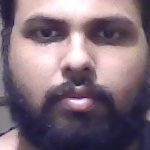

Clipped bounding box width: 140, height: 140
Clipped bounding box coordinates: x=278, y=233
Face detected with size: (140, 140, 3)
Face detected in new image.
New face size: (140, 140, 3)


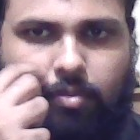

Stored face shape: (150, 150, 3), dtype: uint8
New face shape: (140, 140, 3), dtype: uint8
No face detected in the image for embedding.
Failed to extract embedding from stored face.


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# ATTEMPT 20

In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Display the stored face for inspection
        print("Displaying stored face:")
        cv2_imshow(stored_face)

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Display the new face for inspection
        print("Displaying new face:")
        cv2_imshow(new_face)

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 169, height: 169
Clipped bounding box coordinates: x=214, y=232
Face detected with size: (169, 169, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Clipped bounding box width: 164, height: 164
Clipped bounding box coordinates: x=0, y=0
Face detected with size: (164, 164, 3)
Face detected in stored image.
Displaying stored face:


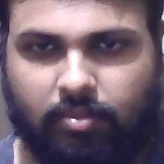

Clipped bounding box width: 171, height: 171
Clipped bounding box coordinates: x=220, y=234
Face detected with size: (171, 171, 3)
Face detected in new image.
Displaying new face:


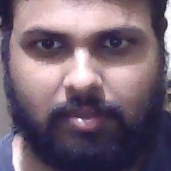

Stored face shape: (164, 164, 3), dtype: uint8
New face shape: (171, 171, 3), dtype: uint8
No face detected in the image for embedding.
Failed to extract embedding from stored face.


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# ATTEMPT 21

In [ ]:
#CELL 1
!pip install torch torchvision insightface opencv-python mediapipe

import cv2
import numpy as np
import torch
import insightface
import mediapipe as mp
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

print("Packages installed and libraries imported successfully.")

Packages installed and libraries imported successfully.


In [ ]:
#CELL 2
# Load the ArcFace model
try:
    model = insightface.app.FaceAnalysis(name='buffalo_l')
    model.prepare(ctx_id=-1)  # Use CPU, set ctx_id=0 for GPU
    print("ArcFace model loaded successfully.")
except Exception as e:
    print(f"Error loading ArcFace model: {e}")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
ArcFace mode

In [ ]:
# CELL 3
# Directory to store captured images
try:
    if not os.path.exists('captured_images'):
        os.makedirs('captured_images')
    print("Directory for captured images is ready.")
except Exception as e:
    print(f"Error setting up directory: {e}")

Directory for captured images is ready.


In [ ]:
# CELL 4
# Initialize Mediapipe Face Detection
try:
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
    print("Mediapipe face detection initialized successfully.")
except Exception as e:
    print(f"Error initializing Mediapipe face detection: {e}")


Mediapipe face detection initialized successfully.


In [ ]:
# CELL 5
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information and strict minimum size enforcement
def detect_and_filter_faces(image, depth_threshold=0.5, min_face_size=(100, 100)):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Calculate the bounding box size and coordinates
                bbox_xmin = max(int(bboxC.xmin * image.shape[1]), 0)
                bbox_ymin = max(int(bboxC.ymin * image.shape[0]), 0)
                bbox_width = int(bboxC.width * image.shape[1])
                bbox_height = int(bboxC.height * image.shape[0])

                # Clip the bounding box coordinates to stay within image boundaries
                bbox_xmax = min(bbox_xmin + bbox_width, image.shape[1])
                bbox_ymax = min(bbox_ymin + bbox_height, image.shape[0])

                # Ensure the width and height are calculated correctly after clipping
                bbox_width = bbox_xmax - bbox_xmin
                bbox_height = bbox_ymax - bbox_ymin

                # Debug: Print the bounding box coordinates and size
                print(f"Clipped bounding box width: {bbox_width}, height: {bbox_height}")
                print(f"Clipped bounding box coordinates: x={bbox_xmin}, y={bbox_ymin}")

                # Filter based on depth and minimum face size
                if depth > depth_threshold and bbox_width >= min_face_size[0] and bbox_height >= min_face_size[1]:
                    face = image[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
                    print(f"Face detected with size: {face.shape}")
                    return face

        print("No face detected or face size below minimum threshold.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        # Ensure the face image is of the expected size for the model (e.g., 112x112 for ArcFace)
        required_size = (112, 112)  # This size depends on your model; adjust as necessary
        face_resized = cv2.resize(face_img, required_size)

        # Convert image to RGB if needed
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

        # Normalize the image as required by the model
        face_normalized = (face_rgb - 127.5) / 128.0

        # Prepare the input for the model
        face_input = np.expand_dims(face_normalized, axis=0)  # Add batch dimension

        faces = model.get(face_input)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None



In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Display the stored face for inspection
        print("Displaying stored face:")
        cv2_imshow(stored_face)

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Display the new face for inspection
        print("Displaying new face:")
        cv2_imshow(new_face)

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 144, height: 144
Clipped bounding box coordinates: x=245, y=231
Face detected with size: (144, 144, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 147, height: 147
Clipped bounding box coordinates: x=242, y=231
Face detected with size: (147, 147, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 146, height: 146
Clipped bounding box coordinates: x=242, y=232
Face detected with size: (146, 146, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 148, height: 148
Clipped bounding box coordinates: x=242, y=234
Face detected with size: (148, 148, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Clipped bounding box width: 143, height: 143
Clipped bounding box coordinates: x=2, y=0
Face detected with size: (143, 143, 3)
Face detected in stored image.
Displaying stored face:


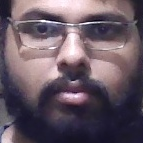

Clipped bounding box width: 145, height: 145
Clipped bounding box coordinates: x=245, y=236
Face detected with size: (145, 145, 3)
Face detected in new image.
Displaying new face:


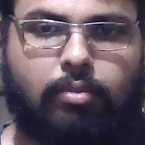

Stored face shape: (143, 143, 3), dtype: uint8
New face shape: (145, 145, 3), dtype: uint8
Error extracting face embedding: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'

Failed to extract embedding from stored face.


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# ATTEMPT 22 , THE LAST ONE OF THIS TYPE

In [ ]:
# CELL 5
# Function to decode the image
def data_uri_to_image(data_uri):
    try:
        image_data = b64decode(data_uri.split(',')[1])
        np_array = np.frombuffer(image_data, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        print("Image decoded successfully.")
        return img
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Function to filter and detect faces with depth information and strict minimum size enforcement
def detect_and_filter_faces(image, depth_threshold=0.5, min_face_size=(100, 100)):
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Extract bounding box and depth information
                bboxC = detection.location_data.relative_bounding_box
                depth = detection.score[0]  # Depth confidence (as a proxy)

                # Calculate the bounding box size and coordinates
                bbox_xmin = max(int(bboxC.xmin * image.shape[1]), 0)
                bbox_ymin = max(int(bboxC.ymin * image.shape[0]), 0)
                bbox_width = int(bboxC.width * image.shape[1])
                bbox_height = int(bboxC.height * image.shape[0])

                # Clip the bounding box coordinates to stay within image boundaries
                bbox_xmax = min(bbox_xmin + bbox_width, image.shape[1])
                bbox_ymax = min(bbox_ymin + bbox_height, image.shape[0])

                # Ensure the width and height are calculated correctly after clipping
                bbox_width = bbox_xmax - bbox_xmin
                bbox_height = bbox_ymax - bbox_ymin

                # Debug: Print the bounding box coordinates and size
                print(f"Clipped bounding box width: {bbox_width}, height: {bbox_height}")
                print(f"Clipped bounding box coordinates: x={bbox_xmin}, y={bbox_ymin}")

                # Filter based on depth and minimum face size
                if depth > depth_threshold and bbox_width >= min_face_size[0] and bbox_height >= min_face_size[1]:
                    face = image[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
                    print(f"Face detected with size: {face.shape}")
                    return face

        print("No face detected or face size below minimum threshold.")
        return None
    except Exception as e:
        print(f"Error detecting and filtering faces: {e}")
        return None

# Function to extract face embedding using ArcFace
def get_face_embedding(face_img):
    try:
        # Ensure the face image is of the expected size for the model (e.g., 112x112 for ArcFace)
        required_size = (112, 112)  # This size depends on your model; adjust as necessary

        # Check if the face image is valid before resizing
        if face_img is None or face_img.size == 0:
            print("Invalid face image provided for embedding.")
            return None

        # Resize the face image to the required size
        face_resized = cv2.resize(face_img, required_size)

        # Convert image to RGB if needed
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

        # Normalize the image as required by the model
        face_normalized = (face_rgb - 127.5) / 128.0

        # Prepare the input for the model
        face_input = np.expand_dims(face_normalized, axis=0)  # Add batch dimension

        faces = model.get(face_input)
        if len(faces) > 0:
            print("Face embedding extracted successfully.")
            return faces[0].embedding
        else:
            print("No face detected in the image for embedding.")
            return None
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None



In [ ]:
# CELL 6
from google.colab.patches import cv2_imshow

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")
        print(f"Stored image path: {stored_image_path}")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_and_filter_faces(stored_image)
        if stored_face is None or stored_face.size == 0:
            print("No face detected in stored image or face image has zero size.")
            return False, 0
        print("Face detected in stored image.")

        # Display the stored face for inspection
        print("Displaying stored face:")
        cv2_imshow(stored_face)

        new_face = detect_and_filter_faces(new_image)
        if new_face is None or new_face.size == 0:
            print("No face detected in new image or face image has zero size.")
            return False, 0
        print("Face detected in new image.")

        # Display the new face for inspection
        print("Displaying new face:")
        cv2_imshow(new_face)

        print(f"Stored face shape: {stored_face.shape}, dtype: {stored_face.dtype}")
        print(f"New face shape: {new_face.shape}, dtype: {new_face.dtype}")

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0
        print(f"Stored face embedding: {stored_embedding[:5]}... (truncated)")

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0
        print(f"New face embedding: {new_embedding[:5]}... (truncated)")

        stored_norm = np.linalg.norm(stored_embedding)
        new_norm = np.linalg.norm(new_embedding)
        print(f"Stored embedding norm: {stored_norm}")
        print(f"New embedding norm: {new_norm}")

        if stored_norm == 0 or new_norm == 0:
            print("One of the embeddings has zero norm, cannot calculate similarity.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (stored_norm * new_norm)
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
Image decoded successfully.
Clipped bounding box width: 155, height: 155
Clipped bounding box coordinates: x=297, y=235
Face detected with size: (155, 155, 3)
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image for comparison executed.
Initiating comparison...
Starting face comparison...
Stored image path: captured_images/captured_image.jpg
Stored image read successfully.
Image decoded successfully.
New image decoded successfully.
Clipped bounding box width: 155, height: 155
Clipped bounding box coordinates: x=0, y=0
Face detected with size: (155, 155, 3)
Face detected in stored image.
Displaying stored face:


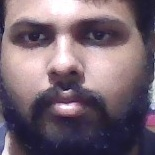

Clipped bounding box width: 153, height: 153
Clipped bounding box coordinates: x=296, y=238
Face detected with size: (153, 153, 3)
Face detected in new image.
Displaying new face:


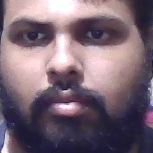

Stored face shape: (155, 155, 3), dtype: uint8
New face shape: (153, 153, 3), dtype: uint8
Error extracting face embedding: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'

Failed to extract embedding from stored face.


In [ ]:
# CELL 7
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('capture', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture image and then trigger the comparison process
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('compare', [dataUrl], {});
        }
        captureImage();
    '''))
    print("JavaScript to capture image for comparison executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_and_filter_faces(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# BRAND NEW APPROACH, USING MTCNN AND FACENET

In [ ]:
!pip install mtcnn facenet-pytorch

In [ ]:
from mtcnn.mtcnn import MTCNN
from facenet_pytorch import InceptionResnetV1
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from base64 import b64decode
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

# Load MTCNN for face detection and alignment (no keep_all argument)
mtcnn = MTCNN()

# Load FaceNet model for embedding extraction
model = InceptionResnetV1(pretrained='vggface2').eval()

# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# CODE 3
# Function to detect face using MTCNN
def detect_face(image):
    try:
        # Use detect_faces method to detect faces
        result = mtcnn.detect_faces(image)
        if result:
            # Extract the bounding box and crop the face
            box = result[0]['box']
            x, y, width, height = box
            face = image[y:y + height, x:x + width]
            print("Face detected and aligned.")
            return face
        else:
            print("No face detected in the image.")
            return None
    except Exception as e:
        print(f"Error detecting face: {e}")
        return None


# Function to extract face embedding using FaceNet
def get_face_embedding(face_img):
    try:
        if face_img is None or face_img.size == 0:
            print("Invalid face image provided for embedding.")
            return None

        # Convert face image to the format expected by FaceNet
        face_tensor = torch.tensor(face_img).permute(2, 0, 1).unsqueeze(0).float() / 255.0

        with torch.no_grad():
            embedding = model(face_tensor)
        print("Face embedding extracted successfully.")
        return embedding.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_face(stored_image)
        if stored_face is None:
            print("Failed to detect a valid face in the stored image.")
            return False, 0
        print("Face detected in stored image.")
        cv2_imshow(stored_face)

        new_face = detect_face(new_image)
        if new_face is None:
            print("Failed to detect a valid face in the new image.")
            return False, 0
        print("Face detected in new image.")
        cv2_imshow(new_face)

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture and compare images executed.
Initiating comparison...
Starting face comparison...
Stored image read successfully.
New image decoded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face detected and aligned.
Face detected in stored image.


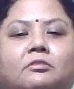

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Face detected and aligned.
Face detected in new image.


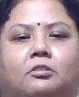

Error extracting face embedding: Calculated padded input size per channel: (3 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
Failed to extract embedding from stored face.


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('capture', [dataUrl], {}));
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture and compare images from the webcam
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('compare', [dataUrl], {}));
    '''))
    print("JavaScript to capture and compare images executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_face(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# MULTI FACE HANDLE

In [ ]:
!pip install mtcnn facenet-pytorch

In [ ]:
from mtcnn.mtcnn import MTCNN
from facenet_pytorch import InceptionResnetV1
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from base64 import b64decode
from IPython.display import display, Javascript
from google.colab import output
import ipywidgets as widgets

# Load MTCNN for face detection and alignment (no keep_all argument)
mtcnn = MTCNN()

# Load FaceNet model for embedding extraction
model = InceptionResnetV1(pretrained='vggface2').eval()

# Function to decode the image
def data_uri_to_image(data_uri):
    image_data = b64decode(data_uri.split(',')[1])
    np_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img


In [ ]:
# CODE 3
# Function to detect and select the closest face using MTCNN
def detect_closest_face(image):
    try:
        results = mtcnn.detect_faces(image)
        if results:
            # Find the face with the largest bounding box
            largest_box = None
            max_area = 0
            closest_face = None
            for result in results:
                box = result['box']
                x, y, width, height = box
                area = width * height
                if area > max_area:
                    max_area = area
                    largest_box = box
                    closest_face = image[y:y + height, x:x + width]

            if closest_face is not None:
                print(f"Closest face detected with bounding box area: {max_area}")
                return closest_face
            else:
                print("No valid face detected.")
                return None
        else:
            print("No face detected in the image.")
            return None
    except Exception as e:
        print(f"Error detecting face: {e}")
        return None



# Function to extract face embedding using FaceNet
def get_face_embedding(face_img):
    try:
        if face_img is None or face_img.size == 0:
            print("Invalid face image provided for embedding.")
            return None

        # Convert face image to the format expected by FaceNet
        face_tensor = torch.tensor(face_img).permute(2, 0, 1).unsqueeze(0).float() / 255.0

        with torch.no_grad():
            embedding = model(face_tensor)
        print("Face embedding extracted successfully.")
        return embedding.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None

# Function to compare faces
def compare_faces(stored_image_path, new_image):
    try:
        print("Starting face comparison...")

        stored_image = cv2.imread(stored_image_path)
        if stored_image is None:
            print("Stored image could not be read.")
            return False, 0
        print("Stored image read successfully.")

        new_image = data_uri_to_image(new_image)
        if new_image is None:
            print("New image could not be decoded.")
            return False, 0
        print("New image decoded successfully.")

        stored_face = detect_face(stored_image)
        if stored_face is None:
            print("Failed to detect a valid face in the stored image.")
            return False, 0
        print("Face detected in stored image.")
        cv2_imshow(stored_face)

        new_face = detect_face(new_image)
        if new_face is None:
            print("Failed to detect a valid face in the new image.")
            return False, 0
        print("Face detected in new image.")
        cv2_imshow(new_face)

        stored_embedding = get_face_embedding(stored_face)
        if stored_embedding is None:
            print("Failed to extract embedding from stored face.")
            return False, 0

        new_embedding = get_face_embedding(new_face)
        if new_embedding is None:
            print("Failed to extract embedding from new face.")
            return False, 0

        similarity = np.dot(stored_embedding, new_embedding) / (np.linalg.norm(stored_embedding) * np.linalg.norm(new_embedding))
        accuracy_percentage = similarity * 100
        match = similarity > 0.6  # Threshold for a match
        print(f"Similarity: {similarity:.4f}, Accuracy: {accuracy_percentage:.2f}%")
        return match, accuracy_percentage
    except Exception as e:
        print(f"Error comparing faces: {e}")
        return False, 0


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture and compare images executed.
Initiating comparison...
Starting face comparison...
Stored image read successfully.
New image decoded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face detected and aligned.
Face detected in stored image.


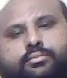

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Face detected and aligned.
Face detected in new image.


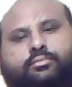

Error extracting face embedding: Calculated padded input size per channel: (3 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
Failed to extract embedding from stored face.


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('capture', [dataUrl], {}));
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture and compare images from the webcam
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('compare', [dataUrl], {}));
    '''))
    print("JavaScript to capture and compare images executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_face(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


Button(description='Capture', style=ButtonStyle())

Button(description='Compare', style=ButtonStyle())

Output()

Buttons and output widgets set up successfully.


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture image executed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Face detected and aligned.
Image captured and saved!


<IPython.core.display.Javascript object>

JavaScript to capture and compare images executed.
Initiating comparison...
Starting face comparison...
Stored image read successfully.
New image decoded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face detected and aligned.
Face detected in stored image.


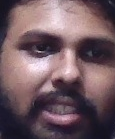

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Face detected and aligned.
Face detected in new image.


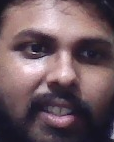

Face embedding extracted successfully.
Face embedding extracted successfully.
Similarity: 0.9287, Accuracy: 92.87%


<IPython.core.display.Javascript object>

JavaScript to capture and compare images executed.
Initiating comparison...
Starting face comparison...
Stored image read successfully.
New image decoded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Face detected and aligned.
Face detected in stored image.


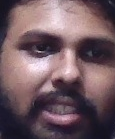

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Face detected and aligned.
Face detected in new image.


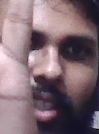

Face embedding extracted successfully.
Face embedding extracted successfully.
Similarity: 0.5280, Accuracy: 52.80%


<IPython.core.display.Javascript object>

JavaScript to capture and compare images executed.
Initiating comparison...
Starting face comparison...
Stored image read successfully.
New image decoded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Face detected and aligned.
Face detected in stored image.


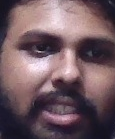

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
No face detected in the image.
Failed to detect a valid face in the new image.


In [ ]:
# JavaScript to capture image from the webcam
def capture_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('capture', [dataUrl], {}));
    '''))
    print("JavaScript to capture image executed.")

# JavaScript to capture and compare images from the webcam
def compare_image_js():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.width = 320;
            video.height = 240;
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video.play());
                };
            });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        captureImage().then(dataUrl => google.colab.kernel.invokeFunction('compare', [dataUrl], {}));
    '''))
    print("JavaScript to capture and compare images executed.")

# Function to save and process the captured image
def capture_image(data_uri):
    img = data_uri_to_image(data_uri)
    face = detect_face(img)

    if face is not None:
        cv2.imwrite('captured_images/captured_image.jpg', face)
        print("Image captured and saved!")
    else:
        print("No face captured.")

# Function to compare the new image with the stored image
def compare_captured_image(data_uri):
    print("Initiating comparison...")
    match, accuracy = compare_faces('captured_images/captured_image.jpg', data_uri)
    result_output.clear_output()
    with result_output:
        if match:
            print(f"Faces match with an accuracy of {accuracy:.2f}%.")
        else:
            print(f"Faces do not match. Accuracy: {accuracy:.2f}%.")

# Register callback functions to be called from JavaScript
output.register_callback('capture', capture_image)
output.register_callback('compare', compare_captured_image)

# Create and display the Capture and Compare buttons
capture_button = widgets.Button(description="Capture")
capture_button.on_click(lambda _: capture_image_js())
display(capture_button)

compare_button = widgets.Button(description="Compare")
compare_button.on_click(lambda _: compare_image_js())
display(compare_button)

# Output widget to display comparison results
result_output = widgets.Output()
display(result_output)

print("Buttons and output widgets set up successfully.")


# Dealing with multiple faces


Presentation Explanation:
In your presentation, you can explain:

- Multiple Face Handling: "Our system can handle multiple faces in the frame. It selects the closest face based on the size of the detected bounding boxes, ensuring that only the face closest to the camera is used for authentication."
- Assumption of Closest Face: "This approach leverages the assumption that the closest face will appear largest in the frame, effectively filtering out faces that are further away."

**Summary:**
This update will enable your system to handle scenarios where multiple people are present, ensuring that only the closest person is authenticated, which aligns with your project goal of using the depth-like feature to select the closest face.